In [55]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from vgg16 import VGG16
import pickle
#from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
import json
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from tqdm import tqdm

In [56]:
token = './annotations/captions_train2014.json'

In [57]:
json_data = open(token)

In [58]:
captions = json.load(json_data)
i = 0
for val in captions['annotations']:
    i+=1
    print(val['id'])
    if i>10:
        break;

48
67
126
148
173
188
219
255
272
288
314


In [59]:
for i, val in enumerate(captions['annotations']):
    if i<10:
        print (val)

{u'image_id': 318556, u'id': 48, u'caption': u'A very clean and well decorated empty bathroom'}
{u'image_id': 116100, u'id': 67, u'caption': u'A panoramic view of a kitchen and all of its appliances.'}
{u'image_id': 318556, u'id': 126, u'caption': u'A blue and white bathroom with butterfly themed wall tiles.'}
{u'image_id': 116100, u'id': 148, u'caption': u'A panoramic photo of a kitchen and dining room'}
{u'image_id': 379340, u'id': 173, u'caption': u'A graffiti-ed stop sign across the street from a red car '}
{u'image_id': 379340, u'id': 188, u'caption': u'A vandalized stop sign and a red beetle on the road'}
{u'image_id': 318556, u'id': 219, u'caption': u'A bathroom with a border of butterflies and blue paint on the walls above it.'}
{u'image_id': 318556, u'id': 255, u'caption': u'An angled view of a beautifully decorated bathroom.'}
{u'image_id': 134754, u'id': 272, u'caption': u'The two people are walking down the beach.'}
{u'image_id': 538480, u'id': 288, u'caption': u'A sink and

In [60]:
for i, val in enumerate(captions['images']):
    if i<2:
        print (val)

{u'license': 5, u'file_name': u'COCO_train2014_000000057870.jpg', u'coco_url': u'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg', u'height': 480, u'width': 640, u'date_captured': u'2013-11-14 16:28:13', u'flickr_url': u'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg', u'id': 57870}
{u'license': 5, u'file_name': u'COCO_train2014_000000384029.jpg', u'coco_url': u'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg', u'height': 429, u'width': 640, u'date_captured': u'2013-11-14 16:29:45', u'flickr_url': u'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg', u'id': 384029}


## Creating a dictionary containing all the captions of the images

In [61]:
images = './train2014/'
len(images)

12

In [62]:
test = './test2014/'
len(test)

11

In [92]:
val = './val2014/'
len(val)

10

In [88]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [89]:
img[:5]

['./train2014/COCO_train2014_000000554778.jpg',
 './train2014/COCO_train2014_000000480685.jpg',
 './train2014/COCO_train2014_000000011519.jpg',
 './train2014/COCO_train2014_000000314201.jpg',
 './train2014/COCO_train2014_000000311715.jpg']

In [90]:
img2 = glob.glob(test+'*.jpg')
img2[:5]

['./test2014/COCO_test2014_000000079287.jpg',
 './test2014/COCO_test2014_000000186110.jpg',
 './test2014/COCO_test2014_000000143685.jpg',
 './test2014/COCO_test2014_000000225671.jpg',
 './test2014/COCO_test2014_000000449608.jpg']

In [94]:
img3 = glob.glob(val+'*.jpg')
img3[:5]

['./val2014/COCO_val2014_000000146397.jpg',
 './val2014/COCO_val2014_000000230040.jpg',
 './val2014/COCO_val2014_000000159977.jpg',
 './val2014/COCO_val2014_000000016593.jpg',
 './val2014/COCO_val2014_000000173109.jpg']

In [68]:
image2id = {}

for i, val in enumerate(captions['images']):
    image2id[val['id']] = val['file_name']

In [69]:
id2captions = {}

for i, val in enumerate(captions['annotations']):
    id2captions[val['image_id']] = val['caption']

In [70]:
image2caption = {}
for key, val in id2captions.items():
    image2caption[image2id[key]] = val

In [71]:
len(image2caption)

82783

In [72]:
image2caption['COCO_train2014_000000554778.jpg']

u'Vacationers sit on the beach under growing banana trees.'

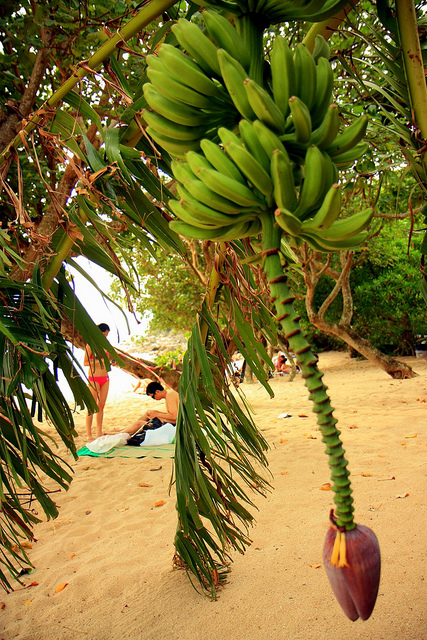

In [73]:
Image.open(img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [74]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [75]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

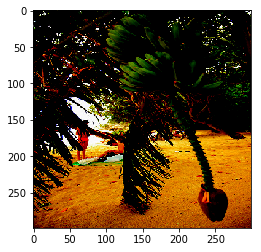

In [76]:
plt.imshow(np.squeeze(preprocess(img[0])))

In [77]:
model = InceptionV3(weights='imagenet')

In [78]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [79]:
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [80]:
tryi = model_new.predict(preprocess(img[0]))

In [81]:
tryi.shape

(1, 2048)

In [82]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

# Need to complete this process

In [83]:
# encoding_train = {}
# for img in tqdm(img):
#     encoding_train[img[len(images):]] = encode(img)

In [84]:
# with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [95]:
encoding_val = {}
for img in tqdm(img3):
    encoding_val[img[len(val):]] = encode(img)
with open("encoded_validation_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

100%|██████████| 40504/40504 [4:24:51<00:00,  2.55it/s]  


In [85]:
encoding_val = pickle.load(open('encoded_val_inceptionV3.p', 'rb'))
encoding_val

{'COCO_val2014_000000350623.jpg': array([0.809758  , 0.13413978, 0.61918724, ..., 0.89603084, 0.22881567,
        1.7937165 ], dtype=float32),
 'COCO_val2014_000000008647.jpg': array([0.9433446 , 0.27265885, 0.6365886 , ..., 0.66908514, 0.8801956 ,
        1.1573946 ], dtype=float32),
 'COCO_val2014_000000443797.jpg': array([0.07916546, 0.5433029 , 0.34183902, ..., 0.13642246, 0.1712874 ,
        0.17480269], dtype=float32),
 'COCO_val2014_000000056205.jpg': array([0.15782548, 0.12221012, 0.3658527 , ..., 0.31375954, 0.08510546,
        0.25239906], dtype=float32),
 'COCO_val2014_000000377984.jpg': array([0.33829266, 0.0150803 , 0.3075199 , ..., 0.02891427, 0.42721495,
        0.42260063], dtype=float32),
 'COCO_val2014_000000279892.jpg': array([0.9152887 , 0.703658  , 0.29410827, ..., 0.05774248, 0.12576059,
        0.17471309], dtype=float32),
 'COCO_val2014_000000103488.jpg': array([0.61797464, 0.15306687, 0.27024764, ..., 0.37421256, 0.40462467,
        0.81827056], dtype=float32),

In [86]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))
encoding_train

{'COCO_train2014_000000487025.jpg': array([0.17690119, 0.06295398, 0.06850533, ..., 0.13567492, 0.27124035,
        0.47264388], dtype=float32),
 'COCO_train2014_000000078077.jpg': array([0.7929996 , 0.568654  , 0.30951068, ..., 0.        , 0.34079328,
        0.29973772], dtype=float32),
 'COCO_train2014_000000501867.jpg': array([0.2111098 , 0.10830129, 0.2978689 , ..., 0.43646252, 0.16785184,
        0.4297196 ], dtype=float32),
 'COCO_train2014_000000497494.jpg': array([1.7535383 , 0.08808857, 0.8509995 , ..., 0.07700095, 0.61649513,
        0.34252635], dtype=float32),
 'COCO_train2014_000000166702.jpg': array([0.7225636 , 0.4308987 , 0.73029137, ..., 0.22006613, 0.03930865,
        0.62557954], dtype=float32),
 'COCO_train2014_000000318857.jpg': array([0.3360603 , 0.36132103, 0.17872354, ..., 0.6696795 , 0.4367111 ,
        0.53493154], dtype=float32),
 'COCO_train2014_000000480082.jpg': array([0.1600918 , 1.0662268 , 0.0585432 , ..., 1.0570481 , 1.0585843 ,
        0.41954863], d

In [35]:
# encoding_test = {}
# for img2 in tqdm(img2):
#     encoding_test[img2[len(test):]] = encode(img2)

In [36]:
# with open("encoded_test_images_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [37]:
encoding_test = pickle.load(open('encoded_test_images_inceptionV3.p', 'rb'))
encoding_test

{'COCO_test2014_000000374459.jpg': array([0.26967034, 0.361967  , 0.16410057, ..., 0.40337133, 0.05000768,
        1.015079  ], dtype=float32),
 'COCO_test2014_000000177376.jpg': array([0.14841156, 0.430557  , 0.5041855 , ..., 0.58578765, 0.23080811,
        1.8349159 ], dtype=float32),
 'COCO_test2014_000000013431.jpg': array([0.07886595, 0.35196272, 0.3712638 , ..., 0.38321325, 0.4594138 ,
        0.3951972 ], dtype=float32),
 'COCO_test2014_000000042223.jpg': array([0.13407344, 0.15168099, 0.05796452, ..., 0.91922987, 0.29492763,
        0.27403355], dtype=float32),
 'COCO_test2014_000000230826.jpg': array([0.18615045, 0.5388979 , 0.58075476, ..., 0.45791578, 0.26751712,
        0.30159757], dtype=float32),
 'COCO_test2014_000000370008.jpg': array([0.29150933, 0.26193866, 0.4538784 , ..., 0.4769198 , 0.06367544,
        0.73552966], dtype=float32),
 'COCO_test2014_000000448775.jpg': array([1.1187623 , 0.3224206 , 1.1115575 , ..., 0.19211437, 0.505183  ,
        0.24358958], dtype=fl

In [38]:
len(encoding_test)

40775

Calculating the unique words in the vocabulary.

In [39]:
caps = []
for key, val in image2caption.items():
    caps.append(' '.join(list(val.split())))
    
caps[:5]

[u'a person making a huge vase on a machine',
 u'Two abandoned blue and white train cars next to trees.',
 u'A large red bus on a city street.',
 u'Various people taking shelter underneath umbrellas in the rain.',
 u'A street sign on the city streets of Houston and Luldlow.']

In [40]:
words = [i.split() for i in caps]

In [41]:
unique = []
for i in words:
    unique.extend(i)

In [42]:
unique.extend("<start>".split())
unique.extend("<end>".split())
unique.extend("<unk>".split())

In [43]:
unique = list(set(unique))

In [44]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [45]:
len(unique)

21315

Mapping the unique words to indices and vice-versa

In [46]:
word2idx = {val:index for index, val in enumerate(unique)}

In [47]:
word2idx['<end>']

10736

In [48]:
idx2word = {index:val for index, val in enumerate(unique)}

In [49]:
idx2word[10400]

'<start>'

Calculating the maximum length among all the captions

In [50]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

49

In [51]:
len(unique), max_len

(21315, 49)

In [52]:
vocab_size = len(unique)

In [53]:
vocab_size

21315

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [54]:
f = open('mscoco_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

In [55]:
for key, val in image2caption.items():
    f.write(key + "\t" + "<start> " + val +" <end>" + "\n")

f.close()

In [56]:
df = pd.read_csv('mscoco_training_dataset.txt', delimiter='\t')

In [57]:
df = df.dropna()

In [58]:
df

image_id  \
0      COCO_train2014_000000538424.jpg   
1      COCO_train2014_000000078077.jpg   
2      COCO_train2014_000000501867.jpg   
3      COCO_train2014_000000432933.jpg   
4      COCO_train2014_000000439356.jpg   
5      COCO_train2014_000000318857.jpg   
6      COCO_train2014_000000567121.jpg   
7      COCO_train2014_000000423964.jpg   
8      COCO_train2014_000000081074.jpg   
9      COCO_train2014_000000234391.jpg   
10     COCO_train2014_000000247712.jpg   
11     COCO_train2014_000000142599.jpg   
12     COCO_train2014_000000535130.jpg   
13     COCO_train2014_000000520737.jpg   
14     COCO_train2014_000000244385.jpg   
15     COCO_train2014_000000358405.jpg   
16     COCO_train2014_000000455704.jpg   
17     COCO_train2014_000000272480.jpg   
18     COCO_train2014_000000291855.jpg   
19     COCO_train2014_000000175121.jpg   
20     COCO_train2014_000000131780.jpg   
21     COCO_train2014_000000542165.jpg   
22     COCO_train2014_000000316170.jpg   
23     COCO_train2014_000000129726.jpg   
24     COCO_train2014_000000530160.jpg   
25     COCO_train2014_000000186181.jpg   
26     COCO_train2014_000000208011.jpg   
27     COCO_train2014_000000467063.jpg   
28     COCO_train2014_000000576072.jpg   
29     COCO_train2014_000000444350.jpg   
...                                ...   
83063  COCO_train2014_000000352623.jpg   
83064  COCO_train2014_000000419468.jpg   
83065  COCO_train2014_000000178793.jpg   
83066  COCO_train2014_000000096535.jpg   
83067  COCO_train2014_000000516866.jpg   
83068  COCO_train2014_000000562067.jpg   
83069  COCO_train2014_000000248461.jpg   
83070  COCO_train2014_000000410173.jpg   
83071  COCO_train2014_000000304867.jpg   
83072  COCO_train2014_000000235959.jpg   
83073  COCO_train2014_000000381433.jpg   
83074  COCO_train2014_000000404227.jpg   
83075  COCO_train2014_000000397286.jpg   
83076  COCO_train2014_000000135065.jpg   
83077  COCO_train2014_000000085867.jpg   
83078  COCO_train2014_000000516986.jpg   
83079  COCO_train2014_000000111636.jpg   
83080  COCO_train2014_000000231812.jpg   
83081  COCO_train2014_000000310015.jpg   
83082  COCO_train2014_000000409275.jpg   
83083  COCO_train2014_000000094485.jpg   
83084  COCO_train2014_000000390883.jpg   
83085  COCO_train2014_000000150192.jpg   
83086  COCO_train2014_000000268777.jpg   
83087  COCO_train2014_000000343608.jpg   
83088  COCO_train2014_000000437199.jpg   
83089  COCO_train2014_000000224910.jpg   
83090  COCO_train2014_000000136559.jpg   
83091  COCO_train2014_000000394905.jpg   
83092  COCO_train2014_000000382589.jpg   

                                                captions  
0      <start> a person making a huge vase on a machi...  
1      <start> Two abandoned blue and white train car...  
2        <start> A large red bus on a city street. <end>  
3      <start> Various people taking shelter undernea...  
4      <start> A street sign on the city streets of H...  
5      <start> A guy is on his computer with a kitten...  
6      <start> A woman holding a tennis racquet on a ...  
7      <start> A small boat rowing down the river in ...  
8      <start> A desk with a laptop, monitor, headpho...  
9      <start> A large bird on the edge of a river. <...  
10     <start> A man jumping with a skateboard in a p...  
11     <start> A man playing a casual games of tennis...  
12     <start> Doctor checking results on her compute...  
13     <start> A street sign with a cold and snowy mo...  
14     <start> A giraffe standing in front of a tall ...  
15     <start> a person with a glass of wine near a b...  
16     <start> Cows laying in the grass in a field  <...  
17     <start> Four images showing the living areas o...  
18     <start> A mass transit bus sitting with a bike...  
19       <start> A bus is parked on a closed road. <end>  
20     <start> People flying two whale kites and one ...  
21     <start> A grizzled old pug dog stares into the...  
22     <start> Various platters of breakfast meats, b...  
23     <s

In [59]:
len(df)

82783

In [60]:
c = [i for i in df['captions']]

In [61]:
imgs = [i for i in df['image_id']]

In [62]:
a = c[0]
a, imgs[0]

('<start> a person making a huge vase on a machine <end>',
 'COCO_train2014_000000538424.jpg')

In [63]:
for i in a.split():
    print (i, "=>", word2idx[i])

('<start>', '=>', 10400)
('a', '=>', 8259)
('person', '=>', 620)
('making', '=>', 12205)
('a', '=>', 8259)
('huge', '=>', 2952)
('vase', '=>', 10655)
('on', '=>', 18436)
('a', '=>', 8259)
('machine', '=>', 283)
('<end>', '=>', 10736)


In [64]:
samples_per_epoch = 0
s = 0
for ca in c:
    s+=1
    samples_per_epoch = samples_per_epoch + len(ca.split())-1

In [65]:
print(samples_per_epoch,s)

(948248, 82783)


## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [66]:
def data_generator(df, batch_size=32):
    # Shuffling the dataframe before creating batches
#     df = df.sample(frac=1)
#     c = [i for i in df['captions']]
#     imgs = [i for i in df['image_id']]
    
    partial_caps = []
    images = []
    next_words = []
    count = 0
    while True:
        for i, text in enumerate(c):
            current_image = encoding_train[imgs[i]]
            for j in range(len(text.split())-1):
                count+=1
                if text.split()[j] in word2idx:
                    partial = [word2idx[text.split()[j]]]
                else:
                    partial = [word2idx['<unk>']]
                partial_caps.append(partial)
                # Initializing with zeros to create a one-hot encoding matrix
                # This is what we have to predict
                # Hence initializing it with vocab_size length
                next = np.zeros(vocab_size)
                # Setting the next word to 1
                if text.split()[j+1] in word2idx:
                    next[word2idx[text.split()[j+1]]] = 1
                else:
                    next[word2idx['<unk>']] = 1
                next_words.append(next)
                images.append(current_image)

                if count >= batch_size:
                    images = np.array(images)
                    next_words = np.array(next_words)
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    yield [[images, partial_caps], next_words]
                    partial_caps = []
                    images = []
                    next_words = []
                    count = 0
    
    
#     partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
#     return np.array(partial_caps)

## Let's create the model

Input dimension is 2048 since we will feed it the encoded version of the image.

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

Merging the models and creating a softmax classifier

In [67]:
from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoint = ModelCheckpoint('./checkpoint.h5', monitor='val_acc', verbose=1, mode='max')
tensorboard = TensorBoard(log_dir="logs/")
callbacks_list = [checkpoint,tensorboard]

from keras.layers import *
EMBEDDING_DIM=300
concat = Concatenate(axis=1)
input1 = Input(shape=(2048,))
image= Dense(EMBEDDING_DIM, activation='relu')(input1)
img = RepeatVector(1)(image)
input2 = Input(shape=(max_len,))
emb = Embedding(vocab_size, 300, input_length=max_len)(input2)
lang= LSTM(256,return_sequences=True)(emb)
lang= TimeDistributed(Dense(EMBEDDING_DIM))(lang)
x = concat([img,lang])
x = Bidirectional(LSTM(256, return_sequences=False))(x)
x = Dense(vocab_size)(x)
pred = Activation('softmax')(x)
model = Model(inputs=[input1,input2],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      6394500     input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [68]:
model.load_weights('./checkpoint.h5')

In [ ]:
model.fit_generator(data_generator(df,batch_size=512), epochs=200, steps_per_epoch=82783/512, verbose=1, callbacks=callbacks_list)

In [ ]:
model.save_weights('./captioning.h5')

## Predict funtion

In [69]:
def predict_captions(image):
    start_word = ["<start>"]
    total_lp = 0
    wc = 0
    while True:
        par_caps = [word2idx[start_word[-1]]]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(test):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = np.argmax(preds[0])
        total_lp += np.log(np.max(preds[0]))
        print(wc, word_pred,total_lp)
        word_pred = idx2word[word_pred]
        #print(par_caps,e,preds,word_pred)
        if word_pred in word2idx:
            start_word.append(word_pred)
        else:
            start_word.append("<UNK>")
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
        wc += 1
    print(total_lp)
    return ' '.join(start_word[1:-1])

In [70]:
try_image = img2[20]

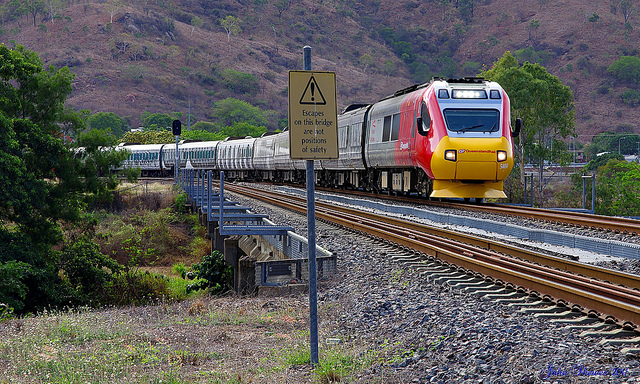

In [71]:
Image.open(try_image)

In [72]:
print ('Normal Max search:', predict_captions(try_image)) 

(0, 294, -0.6411200165748596)
(1, 4340, -1.4979724287986755)
(2, 11549, -3.220849931240082)
(3, 13619, -4.865026414394379)
(4, 11797, -5.234635770320892)
(5, 6308, -5.876135230064392)
(6, 8077, -7.472027659416199)
(7, 10736, -8.97265613079071)
-8.97265613079071
('Normal Max search:', u'A train is coming down the tracks')


In [94]:
def beam(image, k):
    k_beam = [(0, [word2idx["<start>"]])]
    e = []
    j = 0
    for l in range(1,15):
        all_k_beams = []
        end_k_beams = []
        for prob, sent_predict in k_beam:
            e = encoding_test[image[len(test):]]
            
            par_caps = [sent_predict[-1]]
            par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
            
            predicted = model.predict([np.array([e]), np.array(par_caps)])
            predicted=predicted[0]
            for next_wid in range(len(predicted)):
#                 print(next_wid,predicted[next_wid])
#                 if next_wid == 10736:
#                     end_k_beams.append((logprob_for_seq, new_possible_sent))
# #                     logprob_for_wid = np.log(predicted[next_wid])
#                     logprob_for_seq = prob + logprob_for_wid
#                     new_possible_sent = sent_predict[:]  
#                     new_possible_sent.append(next_wid)
#                     all_k_beams.append((logprob_for_seq, new_possible_sent))
                logprob_for_wid = np.log(predicted[next_wid])
                logprob_for_seq = prob + logprob_for_wid
                new_possible_sent = sent_predict[:]  
                new_possible_sent.append(next_wid)
                all_k_beams.append((logprob_for_seq, new_possible_sent))
                
        #print(end_k_beams)       
        k_beam = sorted(all_k_beams)[-k:]
    res=[]
    for lp, widx in sorted(k_beam)[-1:]:
        
        for wid in widx:
            
            if wid==10736:
                return ' '.join(res[1:])
            res.append(idx2word[wid])
    
        
    

In [95]:
max_len =49

In [ ]:
b = beam(try_image, 5)

In [ ]:
print b

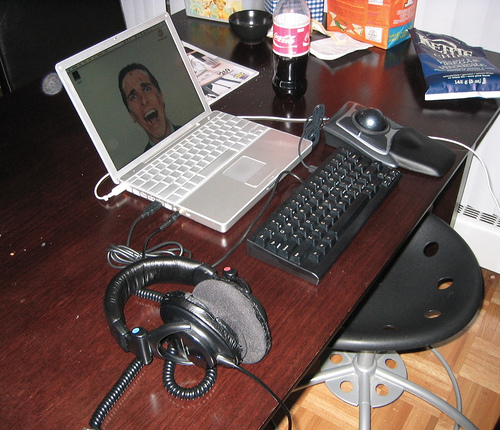

In [69]:
try_image = img2[112]
Image.open(try_image)

In [70]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

('Normal Max search:', u'A laptop computer and a wooden table')
('Beam Search, k=3:', u'A A A An The The The The The The The The The The The The The The The The The The The The The The The The The The The The The Two The The A The A The A A A The The The The The')
('Beam Search, k=5:', u'A A A A The The The The The The The The Two Two Two Two Two Two A The The The The The Two Two Two The Two Two Two A Two Two Two Two Two Two A A The Two Two Two The The The The')
('Beam Search, k=7:', u'A A A There to to Three The A A The A A A The A A The A A The A A A A A A A A A A A A A A A A A A A A The The The The The The The')


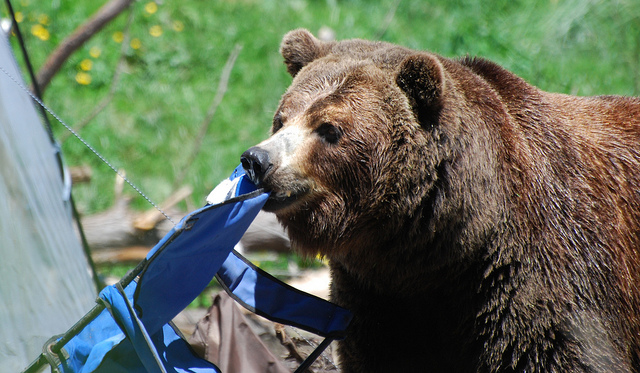

In [71]:
try_image = img2[10]
Image.open(try_image)

In [72]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

('Normal Max search:', u'A brown bear walking across a zoo')
('Beam Search, k=3:', u'A A A A Two Two A Two Two Two Two Two Two Two A Two Two Two A Two Two A Two Two A Two A Two Two Two Two A Two Two Two A A Two A A Two Two Two Two Two Two A Two')
('Beam Search, k=5:', u'A A A A Two Two A Two Two Two Two Two Two Two A Two Two Two A Two Two A Two Two A Two A Two Two Two Two A Two Two Two A A Two A A Two Two Two Two Two Two A Two')
('Beam Search, k=7:', u'A Two A A Two Two Two Two A A Two A A A A A A A A A A A A A Two A Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two Two')


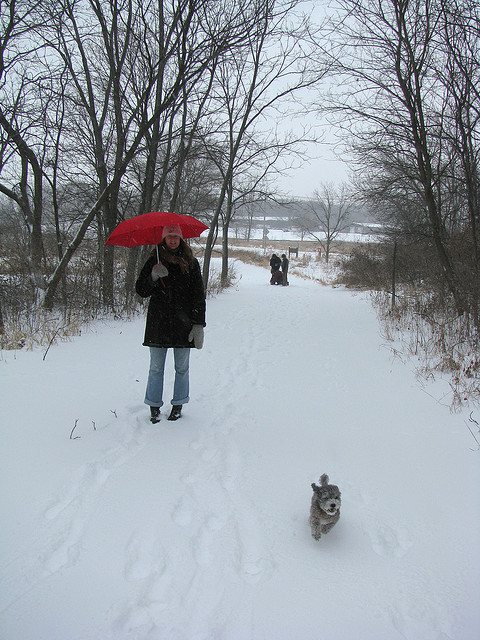

In [78]:
try_image = img2[30]
Image.open(try_image)

In [79]:
print (predict_captions(try_image))
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

A person in the snow.
('Beam Search, k=3:', u'A A A A A The The The The The The The The The The The The The The The Two A The The A A A A A The The The The The The The The The The Two The The The The a The The The')
('Beam Search, k=5:', u'A A A A A The The The The The The The The The The The The The The The A The The The A The A A A The The The The A The The The The A The A The A The The The The The')
('Beam Search, k=7:', u'A A A A A The The The The The The The The The The The The The The The The The Two A Two A The A A Two A A The A A A The The The The The The The The a a The The')
